## The Oren-Nayar (1994) reflectance model

In this notebook we derive and validate our approximation to the Oren-Nayar scattering model.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
import numpy as np
np.seterr(invalid="ignore");

Here's the standard Lambertian reflectance as a function of `b` and `theta` at a point `(x, y)` on the surface, as derived in the Appendix of the `starry` paper. Recall that `b` is the semi-minor axis of the day/night terminator and `theta` is the orientation of the terminator with respect to the `x` axis:

In [4]:
@np.vectorize
def Lambertian(b, theta, x, y):
    """Lambertian intensity at a point on the surface."""
    ct = np.cos(theta)
    st = np.sin(theta)
    bc = np.sqrt(1 - b ** 2)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    ci = -bc * st * x + bc * ct * y - b * z
    return np.maximum(0, ci)

And here's the Oren-Nayar (1994) reflectance from their Equation (30), expressed as a function of the same `starry` parameters:

In [5]:
def R(axis=[0, 1, 0], theta=0):
    """Axis-angle rotation matrix in 3D."""
    axis = np.array(axis) / np.sqrt(np.sum(np.array(axis) ** 2))
    cost = np.cos(theta)
    sint = np.sin(theta)
    return np.reshape(
        [
            cost + axis[0] * axis[0] * (1 - cost),
            axis[0] * axis[1] * (1 - cost) - axis[2] * sint,
            axis[0] * axis[2] * (1 - cost) + axis[1] * sint,
            axis[1] * axis[0] * (1 - cost) + axis[2] * sint,
            cost + axis[1] * axis[1] * (1 - cost),
            axis[1] * axis[2] * (1 - cost) - axis[0] * sint,
            axis[2] * axis[0] * (1 - cost) - axis[1] * sint,
            axis[2] * axis[1] * (1 - cost) + axis[0] * sint,
            cost + axis[2] * axis[2] * (1 - cost),
        ],
        [3, 3],
    )


@np.vectorize
def OrenNayarExplicit(b, theta, sig, x, y):
    """Oren-Nayar intensity at a point on the surface from Equation (30) in Oren & Nayar (1994)."""

    # Compute the three vectors in the observer (sky) frame
    bc = np.sqrt(1 - b ** 2)
    s0 = np.array([-bc * np.sin(theta), bc * np.cos(theta), -b])  # source vector
    v0 = np.array([0, 0, 1.0])  # observer vector
    n0 = np.array([x, y, np.sqrt(1 - x ** 2 - y ** 2)])  # normal vector

    # Transform to the surface normal frame (in which the Oren-Nayar model is defined)
    n = np.array([0, 0, 1.0])  # normal vector

    # Find the rotation matrix that transforms to
    # the normal frame
    axis = np.cross(n0, n)
    costhet = np.dot(n0, n)
    thet = np.arccos(costhet)
    Rn = R(axis, -thet)

    # Check that the sign is right
    # Rn.dot(n0) should be equal to n
    # (if it's not, we need to rotate
    # by `thet`, not `-thet`)
    Rnp = R(axis, thet)
    if Rnp.dot(n0)[2] > Rn.dot(n0)[2]:
        Rn = Rnp

    # Rotate s and v
    s = Rn.dot(s0)
    v = Rn.dot(v0)

    # Compute the angles
    theta_r = np.arccos(np.dot(v, n))
    theta_i = np.arccos(np.dot(s, n))
    if theta_i >= np.pi / 2:
        # Unilluminated!
        return 0
    phi_r = np.arctan2(v[1], v[0])
    phi_i = np.arctan2(s[1], s[0])
    del_phi = phi_i - phi_r

    # Now compute the intensity
    alpha = max(theta_r, theta_i)
    beta = min(theta_r, theta_i)
    f = max(0, np.cos(del_phi)) * np.sin(alpha) * np.tan(beta)
    sig2 = sig ** 2
    A = 1 - 0.5 * sig2 / (sig2 + 0.33)
    B = 0.45 * sig2 / (sig2 + 0.09)
    S = A + B * f

    return Lambertian(b, theta, x, y) * S

First, we're going to show that the above model is equivalent to the following, much simpler, equation:

In [6]:
@np.vectorize
def OrenNayar(b, theta, sig, x, y):
    """Oren-Nayar intensity at a point on the surface (simplified)."""
    ct = np.cos(theta)
    st = np.sin(theta)
    bc = np.sqrt(1 - b ** 2)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    ci = -bc * st * x + bc * ct * y - b * z
    f1 = -b / z - ci
    f2 = -b / ci - z
    sig2 = sig ** 2
    A = 1 - 0.5 * sig2 / (sig2 + 0.33)
    B = 0.45 * sig2 / (sig2 + 0.09)
    S = A + B * np.maximum(0, np.minimum(f1, f2))
    return Lambertian(b, theta, x, y) * S

Let's plot the two models for a variety of roughnesses and compare the output images:

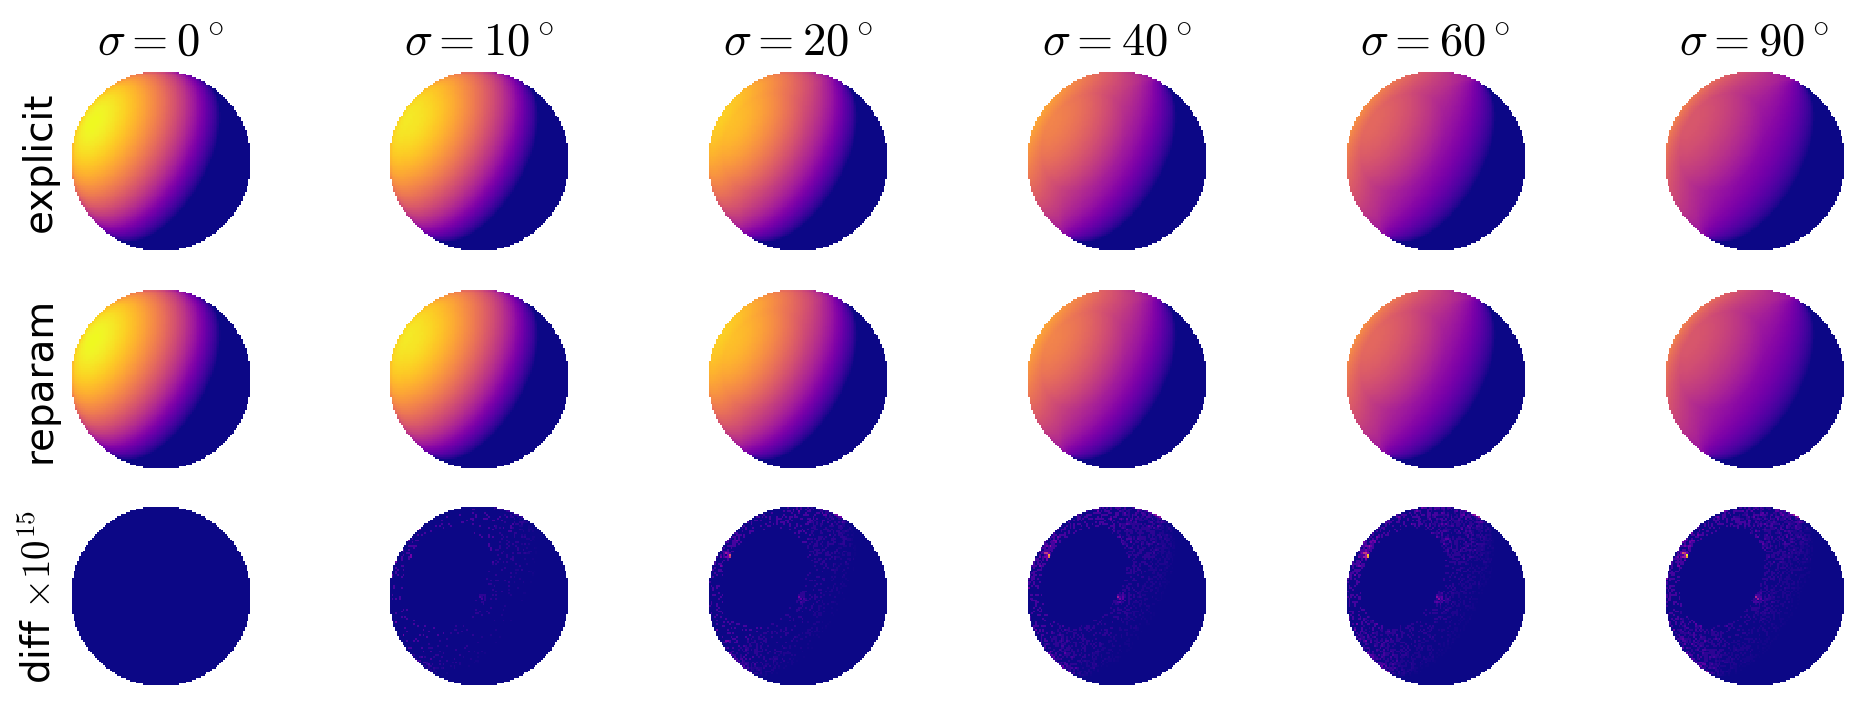

In [9]:
# Params
res = 100
theta = np.pi / 3
b = -0.5
sig = 1.0

# Grid up the surface
grid = np.linspace(-1, 1, res)
x, y = np.meshgrid(grid, grid)

# Plot
fig, ax = plt.subplots(3, 6)
for i, sig in enumerate(np.array([0, 10, 20, 40, 60, 90]) * np.pi / 180):

    # Explicit
    IExplicit = OrenNayarExplicit(b, theta, sig, x, y)
    ax[0, i].imshow(
        IExplicit, origin="lower", extent=(-1, 1, -1, 1), cmap="plasma", vmax=1, vmin=0
    )
    ax[0, i].set(frame_on=False, xticks=[], yticks=[])

    # Re-parametrized
    IReparam = OrenNayar(b, theta, sig, x, y)
    ax[1, i].imshow(
        IReparam, origin="lower", extent=(-1, 1, -1, 1), cmap="plasma", vmax=1, vmin=0
    )
    ax[1, i].set(frame_on=False, xticks=[], yticks=[])

    # Difference
    ax[2, i].imshow(
        np.abs(IExplicit - IReparam),
        origin="lower",
        extent=(-1, 1, -1, 1),
        cmap="plasma",
        vmax=1e-15,
        vmin=0,
    )
    ax[2, i].set(frame_on=False, xticks=[], yticks=[])

    ax[0, i].set_title(r"$\sigma = {:.0f}^\circ$".format(sig * 180 / np.pi))

ax[0, 0].set_ylabel("explicit")
ax[1, 0].set_ylabel("reparam")
ax[2, 0].set_ylabel(r"diff $\times 10^{15}$");

Now, because of the fact that the Oren-Nayar model involves terms like $\frac{1}{z}$ as well as $\text{max}()$ and $\text{min}()$ piecewise functions, there's no way to express it exactly in terms of spherical harmonics (which we need in order for the `starry` algorithm to work). So we need to approximate it with a spherical harmonic expansion. Normally we would use a Taylor expansion, but because of the piecewise nature of the function, we can't get an expansion that's good everywhere. So we'll perform a (regularized) least-squares fit. We'll fit a polynomial in the Cartesian coordinates $x$, $y$, and $z \equiv \sqrt{1 - x^2 - y^2}$ on the projected disk, which has a 1-to-1 correspondence to the spherical harmonics (via the change-of-basis matrix $\mathbf{A_1}$ (c.f. [Luger et al. 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....157...64L/abstract)). Our fit will also include a polynomial in $b$ and $b_c \equiv \sqrt{1 - b^2}$.

Specifically, we are going to fit the non-Lambertian component of the model, which is the function

$$
g \equiv \cos\theta_i f
$$

where

$$
f \equiv \mathrm{max}\left(0, \cos(\phi_r - \phi_i)\right) \sin\alpha \tan\beta
$$

(see the paper for details on what each of the variables mean). We will fit a polynomial to $f$ in a frame in which the illumination source is along the $y-z$ plane, so the terminator angle $\theta = 0$ and the model should be symmetric about the $x$-axis (for different source orientations, we can always rotate the solution in the $x-y$ plane). We will then multiply $f$ by 

$$
\cos\theta_i = b_c y - b z
$$ 

to get $g$. The end result will be the coefficients $w$ of the polynomial fit to $g$,

$$
p(x, y, b) = \sum_{i,j,k,p,q} w_{ijkpq} x^i y^j z^k b^p b_c^q \quad.
$$

for all $i, j, k, p, q$ satisfying

$$
0 \le i < 5, \, i \, \text{even}
\\
0 \le j \le 5
\\
0 \le k \le 1
\\
i + j + k \le 5
\\
1 \le p \le 5
\\
0 \le q \le 4
$$

Note that the lowest power of $b$ is one, since we require that $p(x, y, b = 0) = 0$ everywhere; the simplified Oren-Nayar model (Equation 30 in their paper) is Lambertian at half-phase.

In [10]:
def get_f_exact(x, y, z, b):
    r"""
    Return the expression

    .. math::

        f \equiv
        \mathrm{max}\left(0, \cos(\phi_r - \phi_i)\right)
        \sin\alpha \tan\beta

    from Equation (30) in Oren & Nayar (1994) as a function
    of the Cartesian coordinates on the sky-projected sphere
    seen at a phase where the semi-minor axis of the terminator
    is `b`.

    """
    bc = np.sqrt(1 - b ** 2)
    ci = bc * y - b * z
    f1 = -b / z - ci
    f2 = -b / ci - z
    f = np.maximum(0, np.minimum(f1, f2))
    return f


def get_ijk(n):
    """Get the exponents of x, y, z i the nth term of the polynomial basis."""
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if mu % 2 == 0:
        i = mu // 2
        j = nu // 2
        k = 0
    else:
        i = (mu - 1) // 2
        j = (nu - 1) // 2
        k = 1
    return i, j, k


def poly_basis(x, y, z, deg):
    """Return the polynomial basis evaluated at `x`, `y`, `z`."""
    N = (deg + 1) ** 2
    B = np.zeros((len(x * y * z), N))
    for n in range(N):
        i, j, k = get_ijk(n)
        B[:, n] = x ** i * y ** j * z ** k
    return B


def design_matrix(x, y, z, b, deg, Nb):
    """
    Return the x-y-z-b-bc Vandermonde design matrix.
    
    NOTE: The lowest power of `b` is *ONE*, since
    we need `f = 0` eveywhere when `b = 0` for
    a smooth transition to Lambertian at crescent
    phase.
    
    """
    N = (deg + 1) ** 2
    u = 0
    X = np.zeros((len(y * z * b), N * Nb ** 2))
    bc = np.sqrt(1 - b ** 2)
    B = poly_basis(x, y, z, deg)
    for n in range(N):
        for p in range(1, Nb + 1):
            for q in range(Nb):
                X[:, u] = B[:, n] * b ** p * bc ** q
                u += 1
    return X


def index_of(i, j, k, p, q, deg, Nb):
    """
    Return the index in `w` corresponding to a certain term.
    
    NOTE: Not at all optimized!
    
    """
    idx = 0
    for n in range((deg + 1) ** 2):
        i0, j0, k0 = get_ijk(n)
        for p0 in range(1, Nb + 1):
            for q0 in range(Nb):
                if (
                    (i0 == i)
                    and (j0 == j)
                    and (k0 == k)
                    and (p0 == p)
                    and (q0 == q)
                ):
                    return idx
                idx += 1
    raise IndexError("Invalid polynomial index!")


def get_w(deg=5, Nb=4, res=100, prior_var=1e2):
    """
    Return the coefficients of the 5D fit to `g`
    in `x`, `y`, `z`, `b`, and `bc`.

    We fit the function `f` (see above) with a 
    polynomial of order `deg0 = deg - 1` in `x`, `y`, and `z`
    and `Nb0 = Nb - 1` in `b` and `bc`. We then multiply the
    result by `cos(theta_i)` to get the function `g`, 
    which is just a polynomial of
    order 1 in `y`, `z`, `b`, and `bc`.

    The final polynomial has order `deg` and `Nb` in the
    Cartesian and terminator coordinates, respectively, and is a fit
    to the function

    .. math::

        g \equiv
        \cos\theta_i
        \mathrm{max}\left(0, \cos(\phi_r - \phi_i)\right)
        \sin\alpha \tan\beta

    from Equation (30) in Oren & Nayar (1994).

    """
    # Degrees before multiplying by cos(theta_i)
    deg0 = deg - 1
    Nb0 = Nb - 1

    # Construct a 3D grid in (x, y, b)
    bgrid = np.linspace(-1, 0, res)
    xygrid = np.linspace(-1, 1, res)
    x, y, b = np.meshgrid(xygrid, xygrid, bgrid)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    idx = np.isfinite(z) & (y > b * np.sqrt(1 - x ** 2))
    x = x[idx]
    y = y[idx]
    z = z[idx]
    b = b[idx]

    # Compute the exact `f` function on this grid
    f = get_f_exact(x, y, z, b)

    # Construct the design matrix for fitting
    X = design_matrix(x, y, z, b, deg=deg0, Nb=Nb0)

    # "Data" inverse covariance. Make the errorbars large
    # when cos(theta_i) is small, since the intensity there
    # is small anyways.
    cinv = np.ones_like(f)
    bc = np.sqrt(1 - b ** 2)
    ci = bc * y - b * z
    cinv *= ci ** 2

    # Prior inverse covariance. Make odd powers of x have
    # *very* narrow priors centered on zero, since the
    # function should be symmetric about the y axis.
    # We'll explicitly zero out these coefficients below.
    PInv = np.eye((deg0 + 1) ** 2 * Nb0 ** 2)
    u = 0
    for n in range((deg0 + 1) ** 2):
        i, _, _ = get_ijk(n)
        if (i % 2) != 0:
            inv_var = 1e15
        else:
            inv_var = 1 / prior_var
        for p in range(1, Nb0 + 1):
            for q in range(Nb0):
                PInv[u, u] = inv_var
                u += 1

    # Solve the L2 problem
    XTCInv = X.T * cinv
    w0 = np.linalg.solve(XTCInv.dot(X) + PInv, XTCInv.dot(f),)

    # Zero out really tiny values.
    w0[np.abs(w0) < 1e-10] = 0.0

    # Now multiply by cos_thetai = bc * y - b * z.
    # The powers of x, y, z, b, bc are
    # i, j, k, p, q, respectively
    w = np.zeros((deg + 1) ** 2 * Nb ** 2)
    for n in range((deg0 + 1) ** 2):
        i, j, k = get_ijk(n)
        for p in range(1, Nb0 + 1):
            for q in range(Nb0):
                idx = index_of(i, j, k, p, q, deg0, Nb0)
                w[index_of(i, j + 1, k, p, q + 1, deg, Nb)] += w0[idx]

                if k == 0:
                    w[index_of(i, j, k + 1, p + 1, q, deg, Nb)] -= w0[idx]
                else:
                    # transform z^2 --> 1 - x^2 - y^2
                    w[index_of(i, j, 0, p + 1, q, deg, Nb)] -= w0[idx]
                    w[index_of(i + 2, j, 0, p + 1, q, deg, Nb)] += w0[idx]
                    w[index_of(i, j + 2, 0, p + 1, q, deg, Nb)] += w0[idx]
    return w

We can now test the accuracy of our polynomial fit.

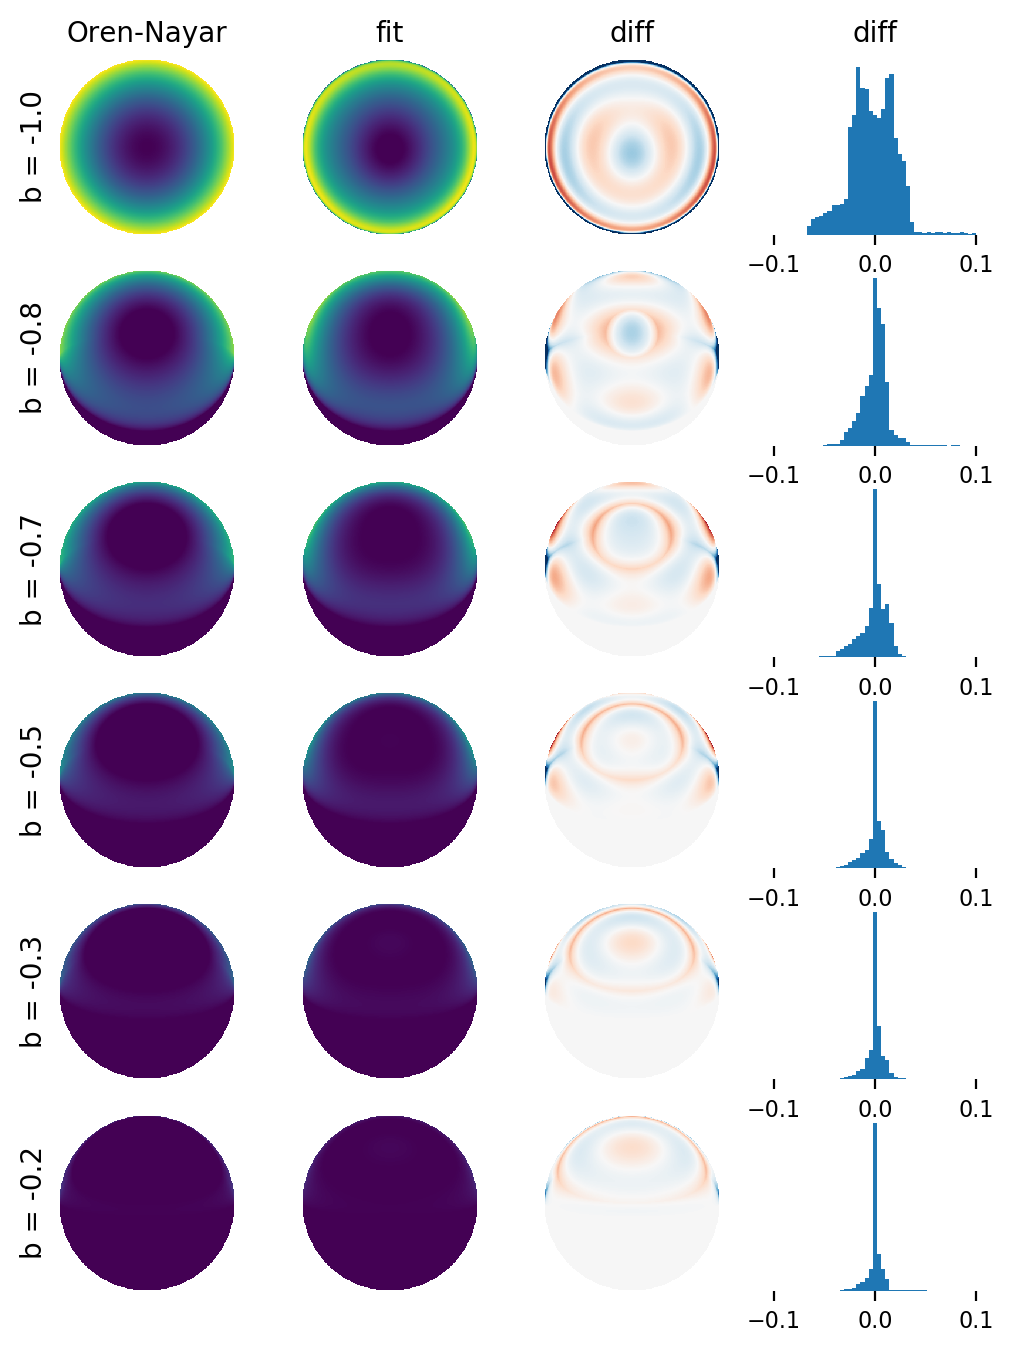

In [15]:
# Get the polynomial coefficients
deg = 5
Nb = 4
w = get_w(deg=deg, Nb=Nb)

# Grid the surface
res = 300
xygrid = np.linspace(-1, 1, res)
x, y = np.meshgrid(xygrid, xygrid)
x = x.reshape(-1)
y = y.reshape(-1)
z = np.sqrt(1 - x ** 2 - y ** 2)

# Compare for several values of b
nimg = 6
fig, ax = plt.subplots(nimg, 4, figsize=(6, 8))
for axis in ax[:, :3].flatten():
    axis.set(frame_on=False, xticks=[], yticks=[])
for axis in ax[:, 3].flatten():
    axis.set(frame_on=False, yticks=[])
    axis.tick_params(labelsize=8)
for i, b in enumerate(np.linspace(-1, 0, nimg, endpoint=False)):

    # Illumination profile
    bc = np.sqrt(1 - b ** 2)
    ci = bc * y - b * z

    # Compute the exact `f` function on this grid
    f = ci * get_f_exact(x, y, z, b)

    # Get our approximation
    X = design_matrix(x, y, z, b, deg=deg, Nb=Nb)
    fapprox = X.dot(w)

    # Mask the nightside & reshape
    idx = np.isfinite(z) & (y < b * np.sqrt(1 - x ** 2))
    f[idx] = 0
    fapprox[idx] = 0
    f = f.reshape(res, res)
    fapprox = fapprox.reshape(res, res)

    # Plot
    vmin = 0
    vmax = 1
    ax[i, 0].imshow(
        f, origin="lower", extent=(-1, 1, -1, 1), vmin=vmin, vmax=vmax
    )
    ax[i, 1].imshow(
        fapprox,
        origin="lower",
        extent=(-1, 1, -1, 1),
        vmin=vmin,
        vmax=vmax,
    )
    ax[i, 2].imshow(
        f - fapprox,
        origin="lower",
        extent=(-1, 1, -1, 1),
        vmin=-0.1,
        vmax=0.1,
        cmap="RdBu",
    )

    bins = np.linspace(-0.1, 0.1, 50)
    ax[i, 3].hist((f - fapprox).flatten(), bins=bins)
    ax[i, 3].set_xlim(-0.1, 0.1)
    
    ax[i, 0].set_ylabel("b = {:.1f}".format(b), fontsize=10)

ax[0, 0].set_title("Oren-Nayar", fontsize=10)
ax[0, 1].set_title("fit", fontsize=10)
ax[0, 2].set_title("diff", fontsize=10)
ax[0, 3].set_title("diff", fontsize=10);

The figure above shows the non-Lambertian component of the observed intensity on the sphere at different illumination phases under the Oren-Nayar model (first column) and our polynomial approximation (second column), normalized so that dark blue = 0 and yellow = 1. The third column shows the difference between the two models, normalized to the range $[-0.1, 0.1]$, and the last column shows a histogram of the differences. In all cases, the polynomial approximation is good to within a few percent of the Oren-Nayar model. At full phase the maximum difference approaches 10% at the very edges, but the contribution of this region to the total flux is tiny.

In `starry`, users may increase the polynomial degree of the approximation by setting the `STARRY_OREN_NAYAR_DEG` macro at compile-time; this will result in better accuracy.

Finally, let's take a look at what the *actual* intensity looks like for a body under the Oren-Nayar model, using `starry`.

In [17]:
import starry

starry.config.lazy = False

Let's instantiate a map:

In [19]:
map = starry.Map(reflected = True)

Pre-computing some matrices... Done.


We'll visualize the map with a varying illumination phase, specified via the source position parameters:

In [ ]:
phase = np.linspace(0, 2 * np.pi, 100)
xs = np.cos(phase)
zs = np.sin(phase)
ys = 0

We now set the `roughness` parameter, which corresponds to the $\sigma$ in the Oren-Nayar model. Note that by default we specify `roughness` in degrees. Let's look at a case with zero roughness (the Lambertian case):

In [30]:
map.roughness = 0
map.show(xs=xs, ys=ys, zs=zs)
flux0 = map.flux(xs=xs, ys=ys, zs=zs)

Compiling `flux`... Done.


Now let's look at a *very* rough surface:

In [31]:
map.roughness = 90
map.show(xs=xs, ys=ys, zs=zs)
flux90 = map.flux(xs=xs, ys=ys, zs=zs)

The difference is most pronounced at full phase, where it is evident that the limb is *much* brighter in the rough case. We can also look at the phase curves of each sphere:

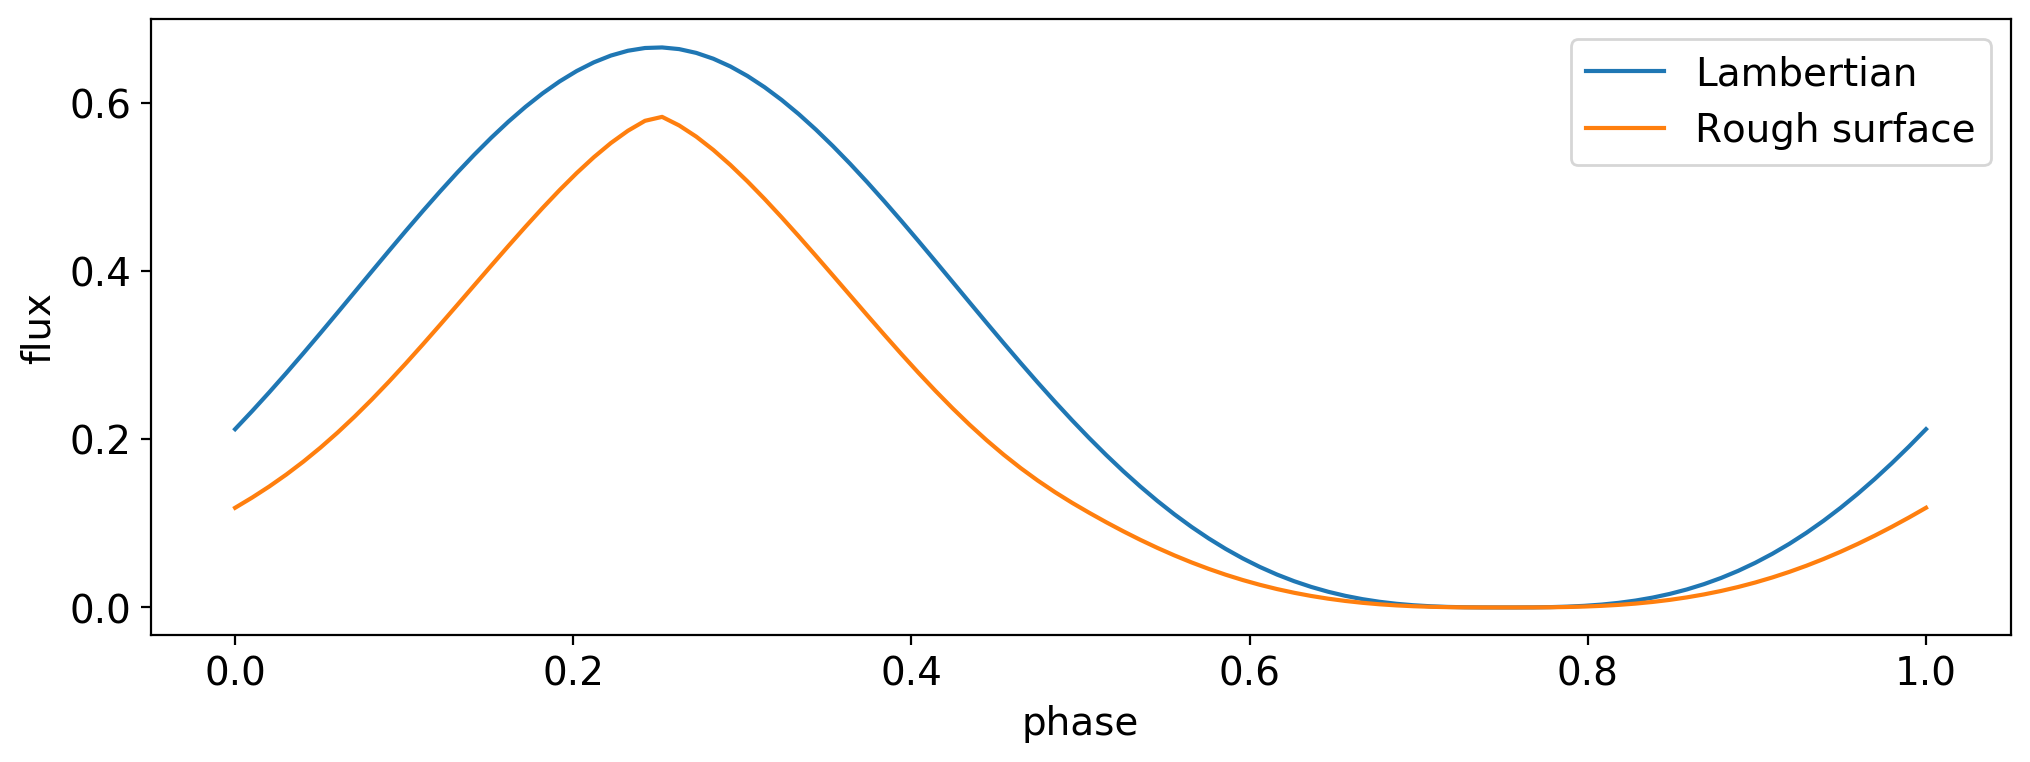

In [35]:
plt.plot(phase / (2 * np.pi), flux0, label="Lambertian")
plt.plot(phase / (2 * np.pi), flux90, label="Rough surface")
plt.legend()
plt.xlabel("phase")
plt.ylabel("flux");